# import modules

In [1]:
# Core data processing and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import csv
import matplotlib.pyplot as plt
import os
import itertools
import time
from collections import defaultdict

# TensorFlow for TensorBoard processing
import tensorflow as tf
from tensorflow.python.framework.errors_impl import DataLossError

# Statistical analysis
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("All imports successful!")

All imports successful!


# Utils

In [2]:
def tensorboard_to_csv(event_file, csv_file):
    """
    Convert TensorBoard event file data to a CSV format.

    Args:
        event_file (str): Path to the TensorBoard event file (e.g., events.out.tfevents.xxx).
        csv_file (str): Path where the output CSV file should be saved.
    """
    data_rows = []
    
    # Use tf.compat.v1 to access the summary_iterator in TensorFlow 2.x
    for e in tf.compat.v1.train.summary_iterator(event_file):
        for v in e.summary.value:
            # Only consider scalar summaries
            if v.HasField('simple_value'):
                tag = v.tag
                value = v.simple_value
                step = e.step
                data_rows.append([step, tag, value])
    
    # Write the extracted data into a CSV file
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Step', 'Tag', 'Value'])
        writer.writerows(data_rows)
    
    print(f"Data from {event_file} has been written to {csv_file}")

def tensorboard_to_separate_csv(event_file, output_dir):
    """
    Convert TensorBoard event file to separate CSV files for each metric.
    
    Args:
        event_file (str): Path to the TensorBoard event file
        output_dir (str): Directory where CSV files should be saved
    """
    tag_data = defaultdict(list)

    try:
        for e in tf.compat.v1.train.summary_iterator(event_file):
            try:
                for v in e.summary.value:
                    if v.HasField('simple_value'):
                        tag = v.tag
                        value = v.simple_value
                        step = e.step
                        tag_data[tag].append([step, value])
            except Exception as record_error:
                print(f"Skipped a corrupt record in file: {event_file}")
    except DataLossError:
        print(f"Encountered DataLossError. Possibly due to incomplete writes in file: {event_file}")

    # Save tag data to CSV files
    for tag, data_rows in tag_data.items():
        filename = f"{output_dir}/{tag.replace('/', '_')}_data.csv"
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Step', 'Value'])
            writer.writerows(data_rows)
        print(f"Data for tag '{tag}' has been written to {filename}")

def is_file_stable(file_path, wait_time=1.0):
    """Check if a file is stable (not being written to)."""
    initial_size = os.path.getsize(file_path)
    time.sleep(wait_time)
    final_size = os.path.getsize(file_path)
    return initial_size == final_size

def process_tensorboard_results(parent_dir, output_parent_dir):
    """
    Process all TensorBoard files in a directory structure.
    
    Args:
        parent_dir (str): Parent directory containing TensorBoard event files
        output_parent_dir (str): Parent directory where CSV files should be saved
    """
    for root, dirs, files in os.walk(parent_dir):
        for file in files:
            if "tfevents" in file:
                event_file = os.path.join(root, file)
                relative_path = os.path.relpath(root, parent_dir)
                output_dir = os.path.join(output_parent_dir, relative_path)
                os.makedirs(output_dir, exist_ok=True)

                try:
                    tensorboard_to_separate_csv(event_file, output_dir)
                    print(f"Processed {event_file} -> {output_dir}")
                except Exception as e:
                    print(f"Failed to process {event_file}: {e}")

# define a rolling window correlation function
from scipy.stats import pearsonr

def check_percentage_of_above_threshold(array, threshold, prop):
    proportion = np.mean(array > threshold)
    if proportion >= prop:
        return 1
    elif np.mean(array < threshold) >= prop:
        return -1
    else:
        return 0

def rolling_window_correlation(x, y, window):
    """
    Calculate the rolling window correlation and p-value between two 1D arrays.

    Args:
        x (array-like): First time series.
        y (array-like): Second time series.
        window (int): Window size for rolling correlation.

    Returns:
        tuple: (corrs, pvals)
            corrs: np.ndarray of correlation coefficients, length = len(x) - window + 1
            pvals: np.ndarray of p-values, same length
    """
    x = np.asarray(x)
    y = np.asarray(y)
    
    if len(x) != len(y):
        raise ValueError("Input arrays must have the same length.")
    if window < 1 or window > len(x):
        raise ValueError("Window size must be between 1 and the length of the input arrays.")

    corrs = []
    pvals = []
    prop =[]
    for i in range(len(x) - window + 1):
        x_win = x[i:i+window]
        y_win = y[i:i+window]
        # Remove nan pairs
        mask = ~np.isnan(x_win) & ~np.isnan(y_win)
        if np.sum(mask) < 2:
            corrs.append(np.nan)
            pvals.append(np.nan)
            prop.append(np.nan)
        else:
            r, p = pearsonr(x_win[mask], y_win[mask])
            corrs.append(r)
            pvals.append(p)
            prop.append(check_percentage_of_above_threshold(x_win[mask], 0.3, 0.6))
    return np.array(corrs), np.array(pvals), np.array(prop)


def trim_and_calculate_mean(array_list):
    """
    Trim arrays to the same length and calculate mean.
    
    Args:
        array_list: List of arrays to process
        
    Returns:
        numpy.ndarray: Array of trimmed arrays
    """
    min_length = min(len(arr) for arr in array_list)
    trimmed_arrays = [arr[:min_length] for arr in array_list]
    return np.array(trimmed_arrays)

def exponential_moving_average(data, alpha):
    """
    Calculate the exponential moving average (EMA) of a 1D array.

    Args:
        data (array-like): The input data
        alpha (float): The smoothing factor (0 < alpha <= 1)

    Returns:
        numpy.ndarray: The EMA values
    """
    if not (0 < alpha <= 1):
        raise ValueError("Alpha must be between 0 and 1.")

    ema = [data[0]]
    for i in range(1, len(data)):
        ema.append(alpha * data[i] + (1 - alpha) * ema[-1])
    return np.array(ema)

def rolling_average(data, window_size):
    """
    Calculate the rolling average of a 1D array.

    Args:
        data (array-like): The input data
        window_size (int): The size of the rolling window

    Returns:
        numpy.ndarray: The rolling average values
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    if len(data) < window_size:
        raise ValueError("Data length must be at least equal to the window size.")
    
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')



# One-step probe test

## Load data

In [ ]:
# for simple probe test
folders = [
#     "test_vis4_area_attack_3a_Nov04_with_epsilon0_stag24_20251106-171737",
#     # "test_vis4_area_attack_3a_Nov04_with_epsilon1_v2_stag24_20251107-010519",
    
#    "test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_20251106-015949",
#    #"test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_with_wound_indicator_20251106-100222",
#    "test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_control_20251106-135145"
# # "test_vis4_area_attack_3a_Nov04_with_epsilon1_v2_stag24_conditional_coop_20251110-233256"
"test_vis4_area_attack_3a_Nov04_with_epsilon1_v2_stag24_conditional_coop_size9_20251112-125150"
]

num_tests_lst = [60000, 60000, 60000]
test_interval = 10
num_tests = 16000
num_a = 2

res = {'test_ind': [], 'cond_idx': []}
for idx, folder in enumerate(folders):
    if len(folders) > 1:
        num_tests = num_tests_lst[idx]
    for test_ind in range(1, num_tests):
        agent_data = {}
        for agent_ind in range(0, num_a):
            for cond in ['upper', 'lower']:
                epoch = int(test_ind * test_interval)
                df = pd.read_csv(f'../data/{folder}/unit_test/test_intention_epoch_{epoch}_agent_{agent_ind}_partner_AgentKinDA_{cond}.csv')
                for col in df.columns[4:]:
                    if col not in list(agent_data.keys()):
                        agent_data[col] = [df[col].mean()]
                    else:
                        agent_data[col].append(df[col].mean())
        if test_ind == 1 and idx == 0:
            for key, item in agent_data.items():
                res[key] = [np.mean(item)]
        else:
            for key, item in agent_data.items():
                res[key].append(np.mean(item))
                
        
    res['test_ind'].extend([x for x in range(1, num_tests)])
    res['cond_idx'].extend([idx for _ in range(1, num_tests)])
res = pd.DataFrame(res)

In [ ]:
# for composite probe tests
folders = [
#     "test_vis4_area_attack_3a_Nov04_with_epsilon0_stag24_20251106-171737",
#     # "test_vis4_area_attack_3a_Nov04_with_epsilon1_v2_stag24_20251107-010519",
    
#    "test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_20251106-015949",
#    #"test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_with_wound_indicator_20251106-100222",
#    "test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_control_20251106-135145"
# # "test_vis4_area_attack_3a_Nov04_with_epsilon1_v2_stag24_conditional_coop_20251110-233256"
"test_vis4_area_attack_3a_Nov04_with_epsilon1_v2_stag24_conditional_coop_size9_20251112-125150"
]

num_tests_lst = [60000, 60000, 60000]
test_interval = 10
num_tests = 120000
num_a = 2

res_partnerA = {'test_ind': [], 'cond_idx': []}
res_partnerB = {'test_ind': [], 'cond_idx': []}
for idx, folder in enumerate(folders):
    if len(folders) > 1:
        num_tests = num_tests_lst[idx]
    for test_ind in range(1, num_tests):
        agent_data_partner_A = {}
        agent_data_partner_B = {}
        for agent_ind in range(0, num_a):
            # agent_ind = 2
            for cond in ['upper', 'lower']:
                epoch = int(test_ind * test_interval)
                df_partner_A = pd.read_csv(f'../data/{folder}/unit_test/test_intention_epoch_{epoch}_agent_{agent_ind}_partner_AgentKinDA_{cond}.csv')
                df_partner_B = pd.read_csv(f'../data/{folder}/unit_test/test_intention_epoch_{epoch}_agent_{agent_ind}_partner_AgentKinDB_{cond}.csv')
                for col in df_partner_A.columns[4:]:
                    if col not in list(agent_data_partner_A.keys()):
                        agent_data_partner_A[col] = [df_partner_A[col].mean()]
                    else:
                        agent_data_partner_A[col].append(df_partner_A[col].mean())
                for col in df_partner_B.columns[4:]:
                    if col not in list(agent_data_partner_B.keys()):
                        agent_data_partner_B[col] = [df_partner_B[col].mean()]
                    else:
                        agent_data_partner_B[col].append(df_partner_B[col].mean()) 
            
        if test_ind == 1 and idx == 0:
            for key, item in agent_data_partner_A.items():
                res_partnerA[key] = [np.mean(item)]
            for key, item in agent_data_partner_B.items():
                res_partnerB[key] = [np.mean(item)]
        else:
            for key, item in agent_data_partner_A.items():
                res_partnerA[key].append(np.mean(item))
            for key, item in agent_data_partner_B.items():
                res_partnerB[key].append(np.mean(item))
                
        
    res_partnerA['test_ind'].extend([x for x in range(1, num_tests)])
    res_partnerA['cond_idx'].extend([idx for _ in range(1, num_tests)])
    res_partnerB['test_ind'].extend([x for x in range(1, num_tests)])
    res_partnerB['cond_idx'].extend([idx for _ in range(1, num_tests)])
res_partnerA = pd.DataFrame(res_partnerA)
res_partnerA['partner'] = 'A'
res_partnerB = pd.DataFrame(res_partnerB)
res_partnerB['partner'] = 'B'
res = pd.concat([res_partnerA, res_partnerB])

In [ ]:
df_partner_A

,epoch,agent_id,map_name,partner_kind,version,q_val_forward,q_val_backward,q_val_step_left,q_val_step_right,q_val_attack,weight_facing_stag,weight_facing_hare
0,10,0,test_intention_probe_test_1.txt,AgentKindA,ver1,-0.099191,-0.176726,-0.027605,-0.189815,-0.139341,0.220414,0.18741


In [136]:
# for probe test validation
folders = [
# "test_probe_test_changes_max_turns5_use_wounded_stag_False_epsilon1_20251118-111848",
# "test_probe_test_changes_max_turns5_use_wounded_stag_False_epsilon0_20251118-121601",
# "test_partial_agent_spawning_max_turns5_use_wounded_stag_False_epsilon0_20251118-143103",
# "test_full_agent_spawning_max_turns5_use_wounded_stag_False_epsilon0_all_can_hunt_20251118-153515"
# "test_full_agent_spawning_max_turns5_use_wounded_stag_False_epsilon1_all_can_hunt_20251118-203613",
# "Nov19_not_all_can_hunt_test_partial_agent_spawning_max_turns5_epsilon0_random_map_20251119-225759",
# "Nov19_test_partial_agent_spawning_max_turns5_epsilon0_random_map_20251119-225614",
# "Nov19_test_partial_agent_spawning_max_turns2_epsilon0_20251119-153332",
# "Nov19_test_partial_agent_spawning_max_turns5_epsilon0_20251119-153429",
# "Nov19_not_all_can_hunt_test_partial_agent_spawning_max_turns5_epsilon0_probe_test_map_20251120-210457",
# "Nov24_not_all_can_hunt_test_partial_agent_spawning_max_turns5_epsilon0_only_stag_20251124-122126",
# "Nov24_not_all_can_hunt_test_partial_agent_spawning_max_turns50_epsilon0_random_map_20251124-122425",
# "Nov24_not_all_can_hunt_test_partial_agent_spawning_max_turns100_epsilon0_random_map_20251124-121629"
# "Nov27_not_all_can_hunt_test_partial_agent_spawning_stag100_max_turns50_epsilon0_random_map_20251127-125150",
# "Nov27_not_all_can_hunt_test_partial_agent_spawning_stag100_max_turns50_epsilon1_random_map_20251127-125045",
# "Nov28_not_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_max_turns50_epsilon0_random_map_20251129-141354"
# "Nov28_not_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_B_cannot_share_max_turns50_epsilon0_random_map_20251202-164751"
#"Nov28_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_max_turns50_epsilon0_random_map_20251129-141444",
"Dec07_not_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_B_cannot_share_max_turns50_epsilon0_random_map_20251207-184551",
# "Dec07_not_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_max_turns50_epsilon0_random_map_20251207-184418"
]

cols = ['q_val_forward', 'q_val_backward', 'q_val_step_left', 'q_val_step_right', 'q_val_attack', 'weight_facing_stag', 'weight_facing_hare']

num_tests_lst = [60000, 60000, 60000]
test_interval = 100
num_tests = 8500
num_a = 2

res_partnerA = {'test_ind': [], 'cond_idx': []}
res_partnerB = {'test_ind': [], 'cond_idx': []}
res_nopartner = {'test_ind': [], 'cond_idx': []}
for idx, folder in enumerate(folders):
    if len(folders) > 1:
        num_tests = num_tests_lst[idx]
    for test_ind in range(1, num_tests):
        agent_data_partner_A = {}
        agent_data_partner_B = {}
        agent_data_nopartner = {}
        for agent_ind in range(0, num_a):
            # agent_ind = 2
            
            for cond in ['ver1', 'ver2']:
                for map_ind in [1, 2, 3, 4]:
                    map_name = f'test_intention_probe_test_{map_ind}'
                    epoch = int(test_ind * test_interval)
                    df_partner_A = pd.read_csv(f'../data/{folder}/unit_test/test_intention_epoch_{epoch}_agent_{agent_ind}_map_{map_name}_partner_AgentKindA_{cond}.csv')
                    df_partner_B = pd.read_csv(f'../data/{folder}/unit_test/test_intention_epoch_{epoch}_agent_{agent_ind}_map_{map_name}_partner_AgentKindB_{cond}.csv')
                    df_nopartner = pd.read_csv(f'../data/{folder}/unit_test/test_intention_epoch_{epoch}_agent_{agent_ind}_map_{map_name}_partner_no_partner_{cond}.csv')
                    for col in cols:
                        if col not in list(agent_data_partner_A.keys()):
                            agent_data_partner_A[col] = [df_partner_A[col].mean()]
                        else:
                            agent_data_partner_A[col].append(df_partner_A[col].mean())
                    for col in cols:
                        if col not in list(agent_data_partner_B.keys()):
                            agent_data_partner_B[col] = [df_partner_B[col].mean()]
                        else:
                            agent_data_partner_B[col].append(df_partner_B[col].mean()) 
                    for col in cols:
                        if col not in list(agent_data_nopartner.keys()):
                            agent_data_nopartner[col] = [df_nopartner[col].mean()]
                        else:
                            agent_data_nopartner[col].append(df_nopartner[col].mean())
            
        if test_ind == 1 and idx == 0:
            for key, item in agent_data_partner_A.items():
                res_partnerA[key] = [np.mean(item)]
            for key, item in agent_data_partner_B.items():
                res_partnerB[key] = [np.mean(item)]
            for key, item in agent_data_nopartner.items():
                res_nopartner[key] = [np.mean(item)]
        else:
            for key, item in agent_data_partner_A.items():
                res_partnerA[key].append(np.mean(item))
            for key, item in agent_data_partner_B.items():
                res_partnerB[key].append(np.mean(item))
            for key, item in agent_data_nopartner.items():
                res_nopartner[key].append(np.mean(item))
                
        
    res_partnerA['test_ind'].extend([x for x in range(1, num_tests)])
    res_partnerA['cond_idx'].extend([idx for _ in range(1, num_tests)])
    res_partnerB['test_ind'].extend([x for x in range(1, num_tests)])
    res_partnerB['cond_idx'].extend([idx for _ in range(1, num_tests)])
    res_nopartner['test_ind'].extend([x for x in range(1, num_tests)])
    res_nopartner['cond_idx'].extend([idx for _ in range(1, num_tests)])
res_partnerA = pd.DataFrame(res_partnerA)
res_partnerA['partner'] = 'A'
res_partnerB = pd.DataFrame(res_partnerB)
res_partnerB['partner'] = 'B'
res_nopartner = pd.DataFrame(res_nopartner)
res_nopartner['partner'] = 'nopartner'
res = pd.concat([res_partnerA, res_partnerB])

## Add rolling metrics

In [87]:
metrics = ['q_val_step_left',
       'q_val_step_right', 'q_val_attack', 'weight_facing_stag',
       'weight_facing_hare', 'ratio_facing_stag_vs_hare']
wsize = 20
res_rolling = res.copy()
res_rolling['ratio_facing_stag_vs_hare'] = res_rolling['weight_facing_stag']/res_rolling['weight_facing_hare']
for metric in metrics:
    res_rolling[f'{metric}_rolling'] = res_rolling.groupby('cond_idx')[metric].rolling(wsize).mean().reset_index(drop=True)
    

In [137]:
metrics = ['q_val_step_left',
       'q_val_step_right', 'q_val_attack', 'weight_facing_stag',
       'weight_facing_hare', 'ratio_facing_stag_vs_hare']
wsize = 50
res_rolling_partnerA = res_partnerA.copy()
res_rolling_partnerA['ratio_facing_stag_vs_hare'] = res_rolling_partnerA['weight_facing_stag']/res_rolling_partnerA['weight_facing_hare']
for metric in metrics:
    res_rolling_partnerA[f'{metric}_rolling'] = res_rolling_partnerA.groupby('cond_idx')[metric].rolling(wsize).mean().reset_index(drop=True)

res_rolling_partnerB = res_partnerB.copy()
res_rolling_partnerB['ratio_facing_stag_vs_hare'] = res_rolling_partnerB['weight_facing_stag']/res_rolling_partnerB['weight_facing_hare']
for metric in metrics:
    res_rolling_partnerB[f'{metric}_rolling'] = res_rolling_partnerB.groupby('cond_idx')[metric].rolling(wsize).mean().reset_index(drop=True)

res_rolling_nopartner = res_nopartner.copy()
res_rolling_nopartner['ratio_facing_stag_vs_hare'] = res_rolling_nopartner['weight_facing_stag']/res_rolling_nopartner['weight_facing_hare']
for metric in metrics:
    res_rolling_nopartner[f'{metric}_rolling'] = res_rolling_nopartner.groupby('cond_idx')[metric].rolling(wsize).mean().reset_index(drop=True)



## Plot

In [ ]:
sns.lineplot(x = 'test_ind', y='weight_facing_hare_rolling', data=res_rolling, label='weight_facing_hare')
sns.lineplot(x = 'test_ind', y='weight_facing_stag_rolling', data=res_rolling, label='weight_facing_stag')


In [9]:
mapping = {
    0: "experimental, eps=0.05",
    1: "experimental, eps=1",
    2: "control, eps=1"
}

res_rolling["cond"] = res_rolling["cond_idx"].map(mapping)

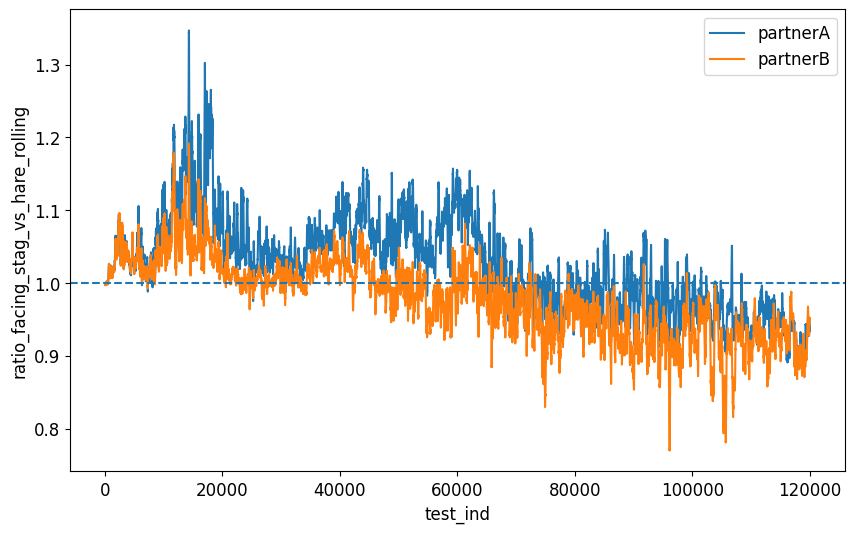

In [7]:
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling',  data=res_rolling_partnerA, label='partnerA')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_partnerB, label='partnerB')
plt.axhline(y=1, linestyle='--')


Text(0, 0.5, 'ratio_facing_stag_vs_hare_rolling')

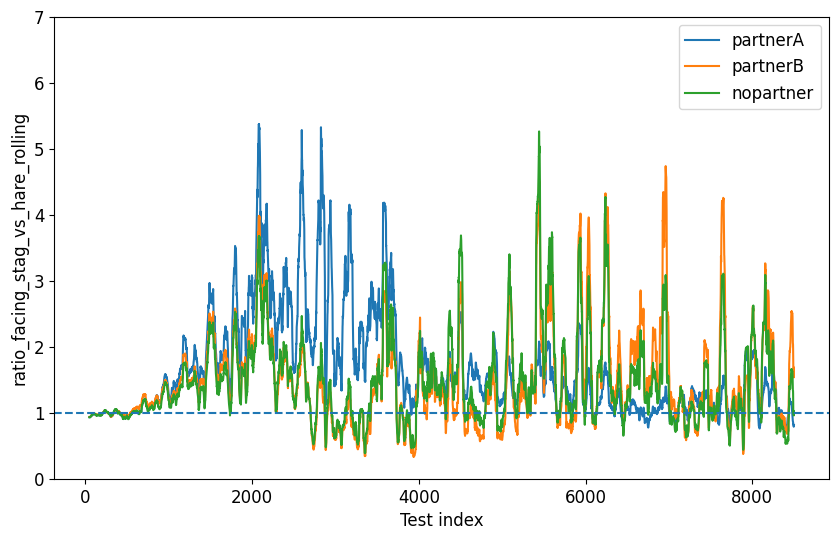

In [135]:
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling',  data=res_rolling_partnerA, label='partnerA')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_partnerB, label='partnerB')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_nopartner, label='nopartner')
plt.axhline(y=1, linestyle='--')
plt.ylim(0, 7) # turns 5 all can hunt typeB
plt.xlabel('Test index')
plt.ylabel('ratio_facing_stag_vs_hare_rolling')

(0.0, 7.0)

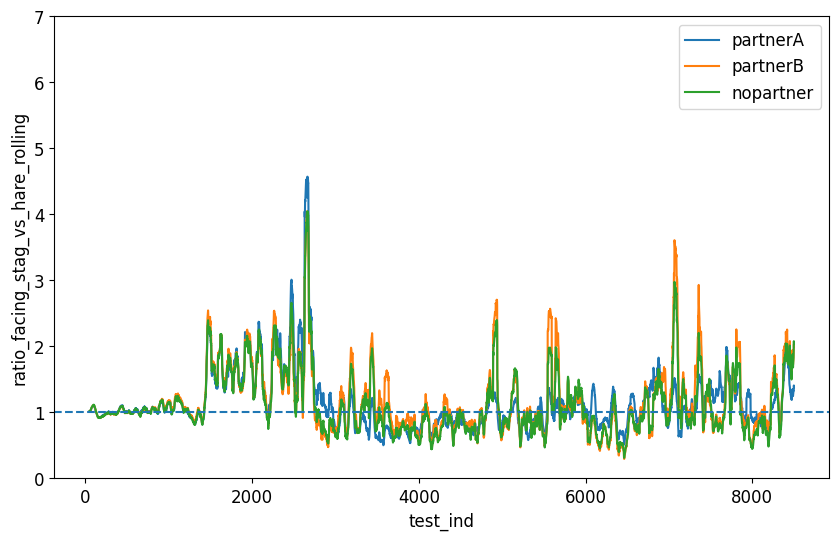

In [139]:
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling',  data=res_rolling_partnerA, label='partnerA')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_partnerB, label='partnerB')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_nopartner, label='nopartner')
plt.axhline(y=1, linestyle='--')
plt.ylim(0, 7) # turns 5 all can hunt tybe A

(0.0, 7.0)

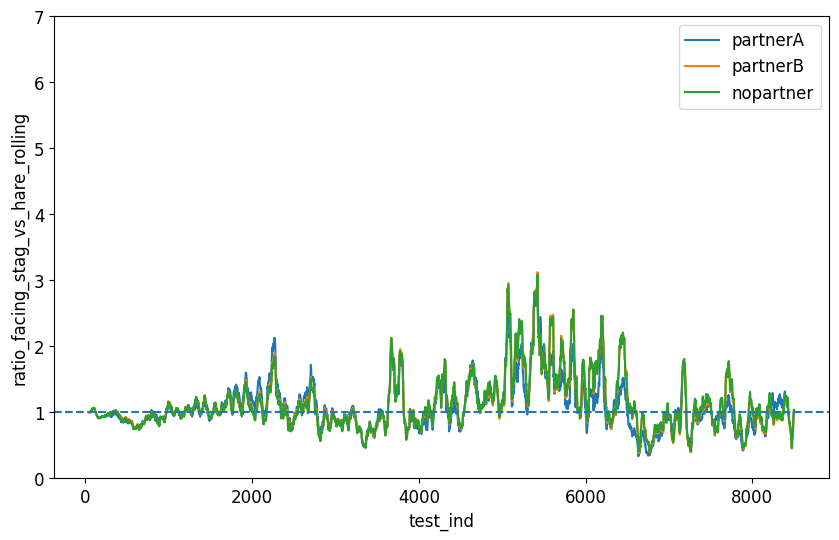

In [131]:
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling',  data=res_rolling_partnerA, label='partnerA')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_partnerB, label='partnerB')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_nopartner, label='nopartner')
plt.axhline(y=1, linestyle='--')
plt.ylim(0, 7) # turns 5 all can hunt typeB

(0.0, 3.0)

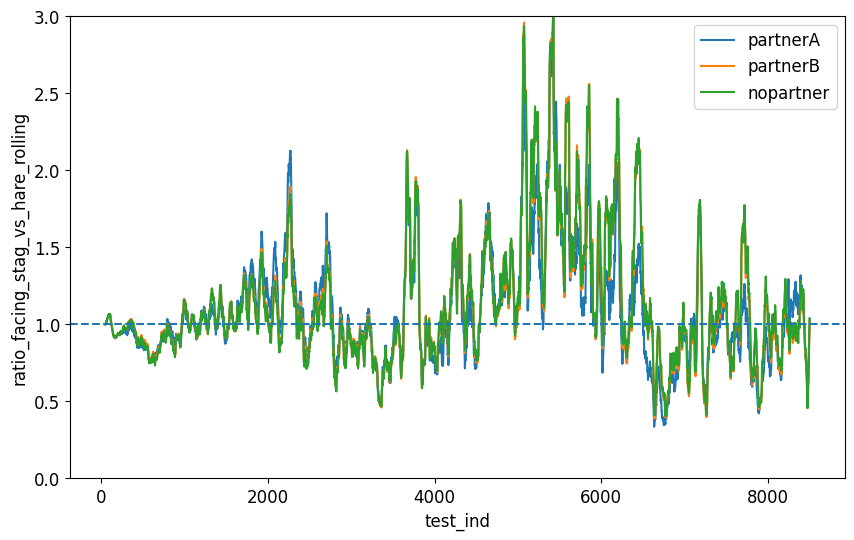

In [130]:
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling',  data=res_rolling_partnerA, label='partnerA')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_partnerB, label='partnerB')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_nopartner, label='nopartner')
plt.axhline(y=1, linestyle='--')
plt.ylim(0,3) # turns 5 all can hunt tybe A

(0.5, 1.5)

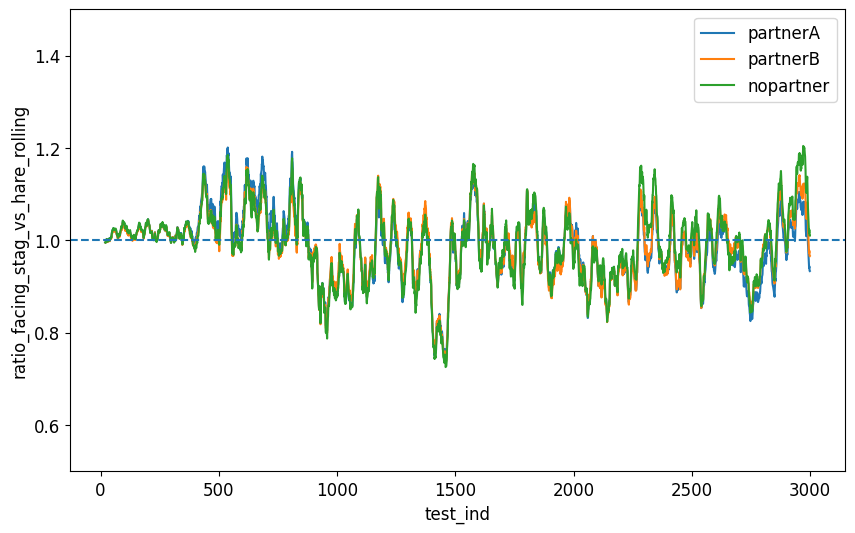

In [190]:
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling',  data=res_rolling_partnerA, label='partnerA')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_partnerB, label='partnerB')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_nopartner, label='nopartner')
plt.axhline(y=1, linestyle='--')
plt.ylim(0.5, 1.5) # turns 5 all can hunt typeB

(0.5, 1.5)

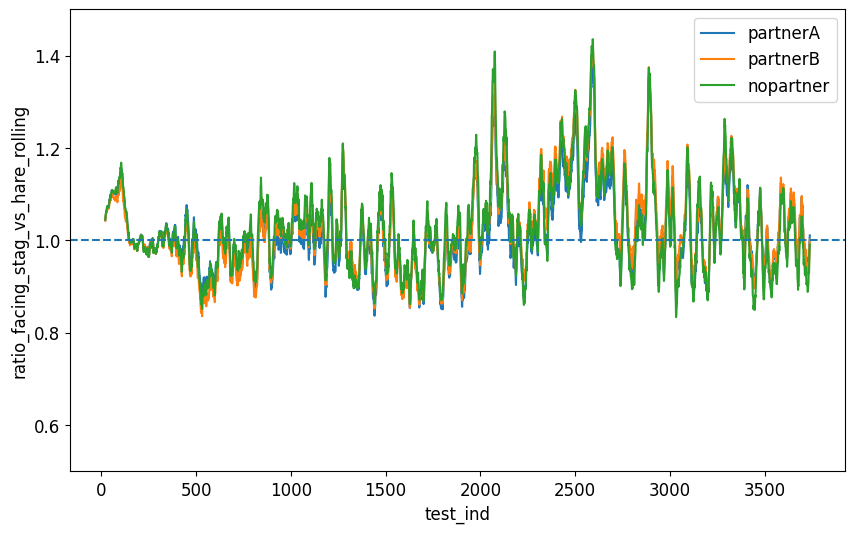

In [193]:
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling',  data=res_rolling_partnerA, label='partnerA')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_partnerB, label='partnerB')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_nopartner, label='nopartner')
plt.axhline(y=1, linestyle='--')
plt.ylim(0.5, 1.5) # turns 5 all can hunt typeB

(0.0, 3.0)

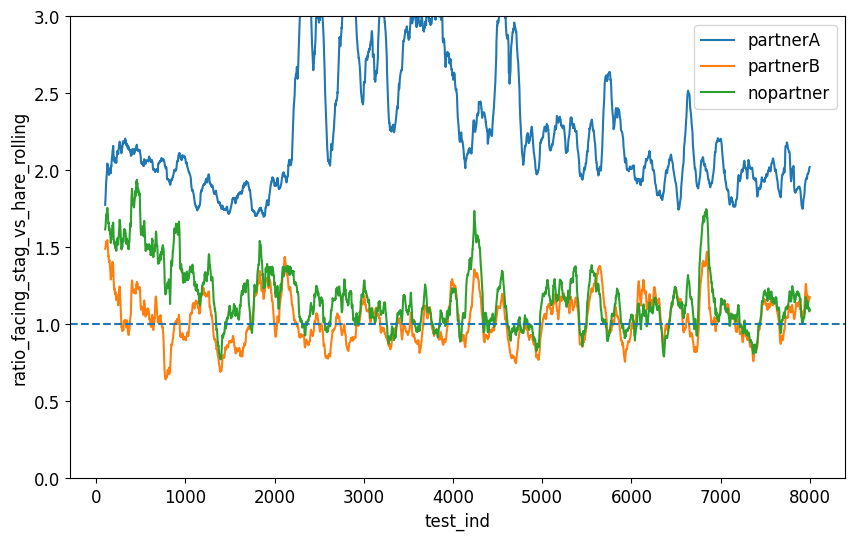

In [54]:
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling',  data=res_rolling_partnerA, label='partnerA')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_partnerB, label='partnerB')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_nopartner, label='nopartner')
plt.axhline(y=1, linestyle='--')
plt.ylim(-0, 3) # turns 2 all can hunt tybe B

(0.0, 3.0)

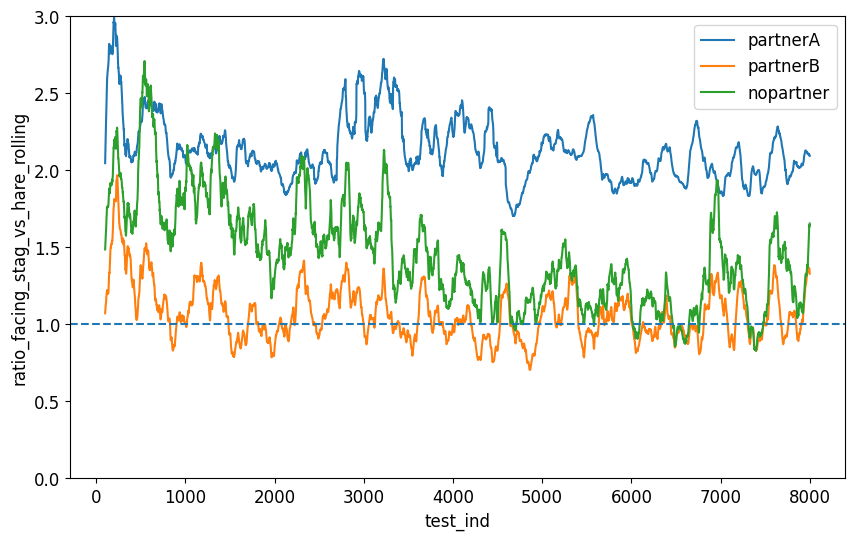

In [59]:
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling',  data=res_rolling_partnerA, label='partnerA')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_partnerB, label='partnerB')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_nopartner, label='nopartner')
plt.axhline(y=1, linestyle='--')
plt.ylim(0, 3) # turns 2 all can hunt tybe A

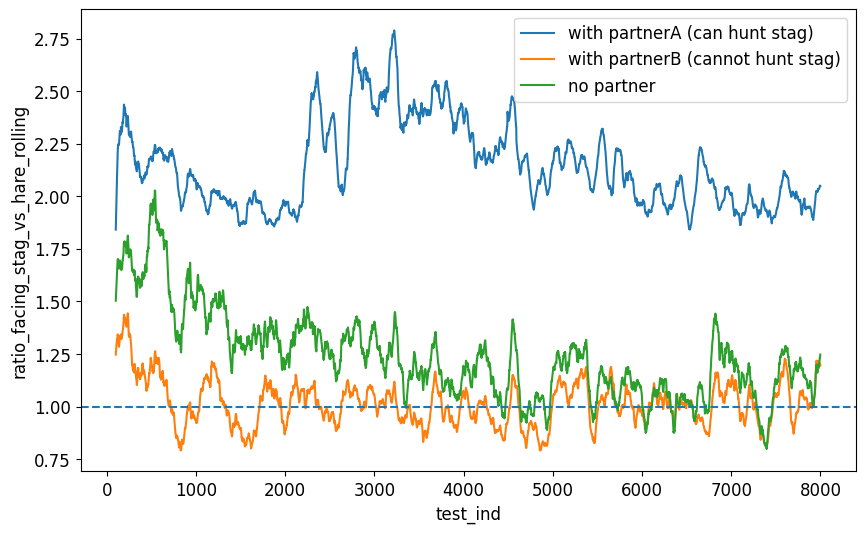

In [64]:
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling',  data=res_rolling_partnerA, label='with partnerA (can hunt stag)')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_partnerB, label='with partnerB (cannot hunt stag)')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_nopartner, label='no partner')
plt.axhline(y=1, linestyle='--')

(0.0, 2.8)

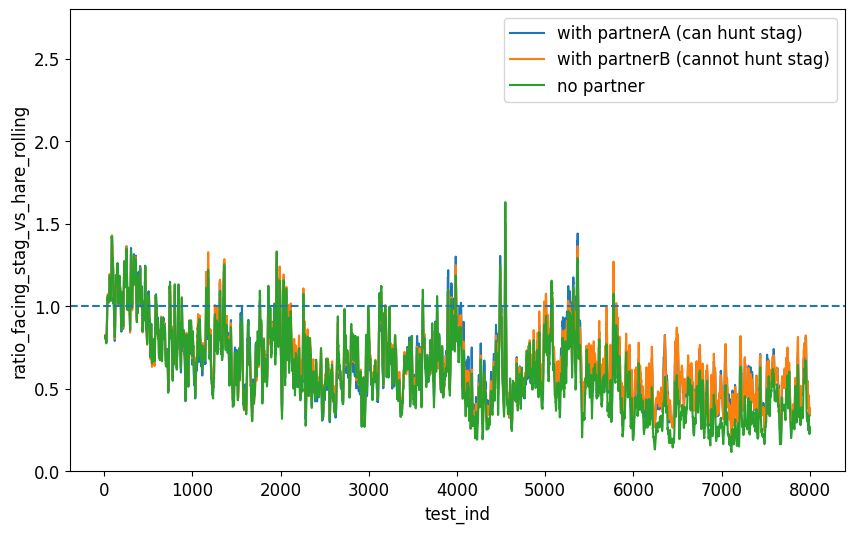

In [105]:
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling',  data=res_rolling_partnerA, label='with partnerA (can hunt stag)')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_partnerB, label='with partnerB (cannot hunt stag)')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_nopartner, label='no partner')
plt.axhline(y=1, linestyle='--')
plt.ylim(0., 2.8)

(0.0, 2.0)

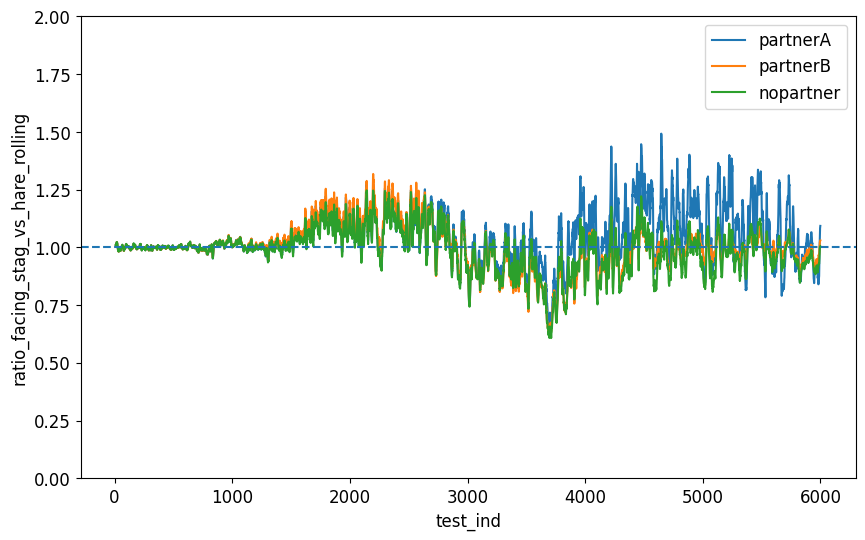

In [6]:
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling',  data=res_rolling_partnerA, label='partnerA')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_partnerB, label='partnerB')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_nopartner, label='nopartner')
plt.axhline(y=1, linestyle='--') 
plt.ylim(0, 2) # partial agent hunting, type A (not all can hunt, random map)


(0.0, 2.0)

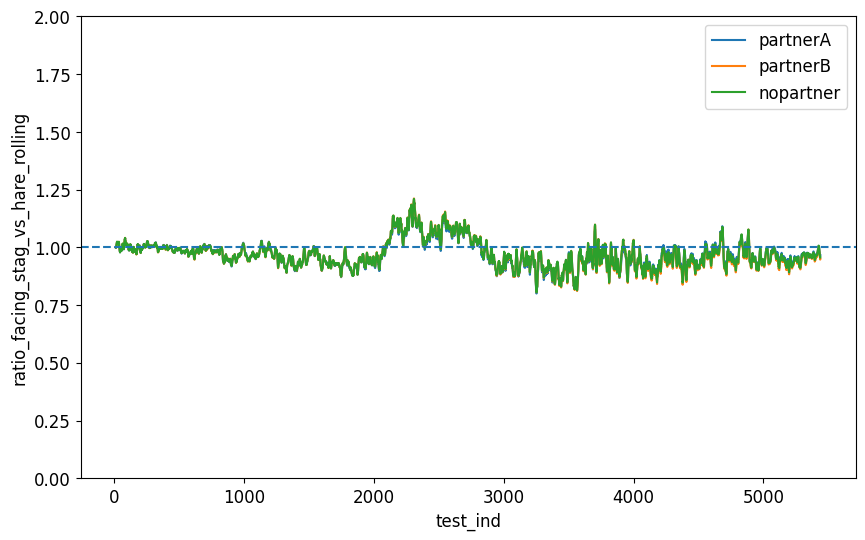

In [15]:
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling',  data=res_rolling_partnerA, label='partnerA')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_partnerB, label='partnerB')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_nopartner, label='nopartner')
plt.axhline(y=1, linestyle='--') 
plt.ylim(0, 2) #partial agent hunting, type B


(0.0, 2.0)

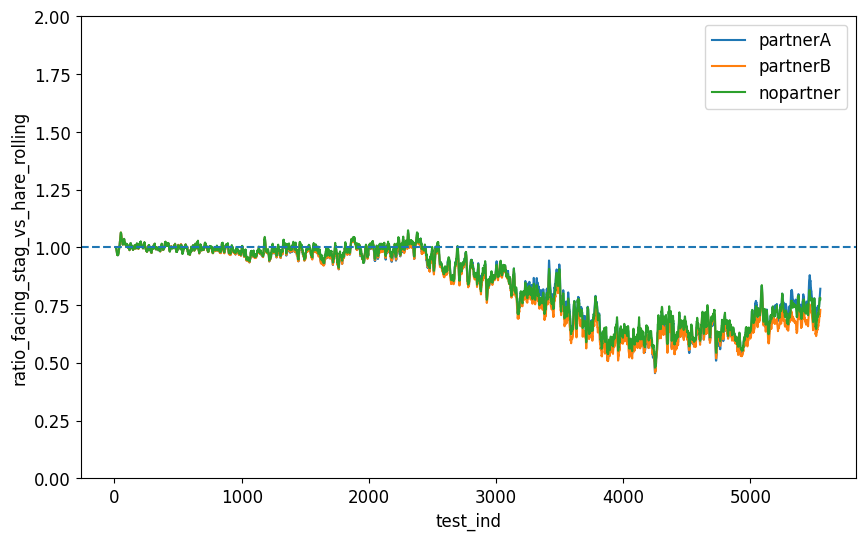

In [18]:
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling',  data=res_rolling_partnerA, label='partnerA')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_partnerB, label='partnerB')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_nopartner, label='nopartner')
plt.axhline(y=1, linestyle='--') 
plt.ylim(0, 2) # all agent can hunt, random map, type A

(0.0, 2.0)

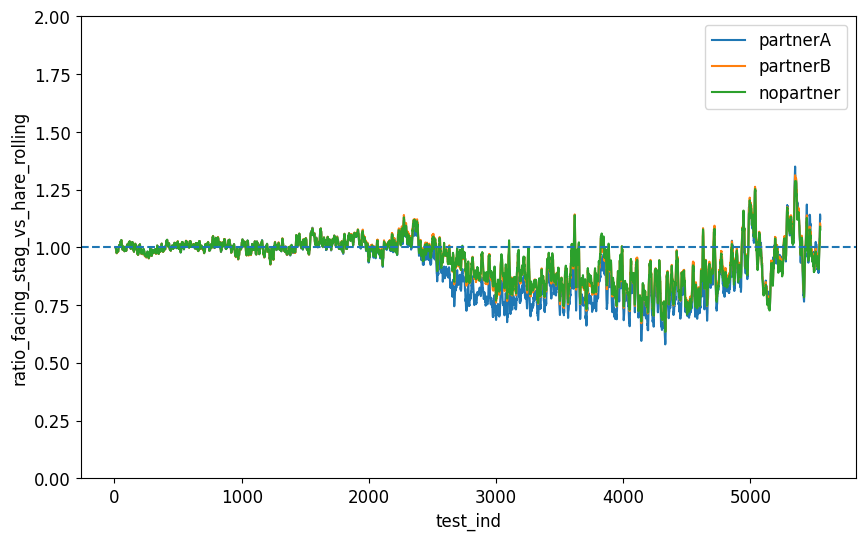

In [23]:
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling',  data=res_rolling_partnerA, label='partnerA')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_partnerB, label='partnerB')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_nopartner, label='nopartner')
plt.axhline(y=1, linestyle='--') 
plt.ylim(0, 2) # all agent can hunt, random map, type B

(0.0, 2.0)

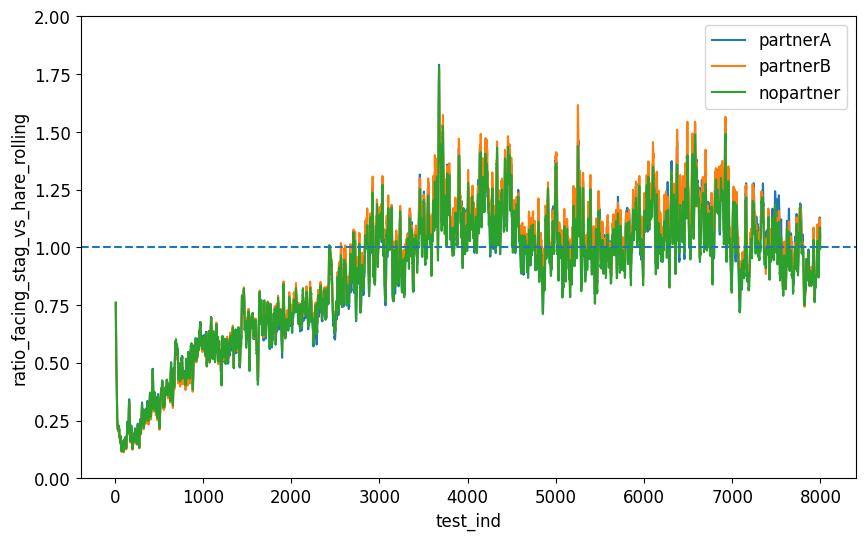

In [8]:
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling',  data=res_rolling_partnerA, label='partnerA')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_partnerB, label='partnerB')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_nopartner, label='nopartner')
plt.axhline(y=1, linestyle='--') 
plt.ylim(0, 2) # partial agent can hunt, ascii map, type A

(0.0, 2.0)

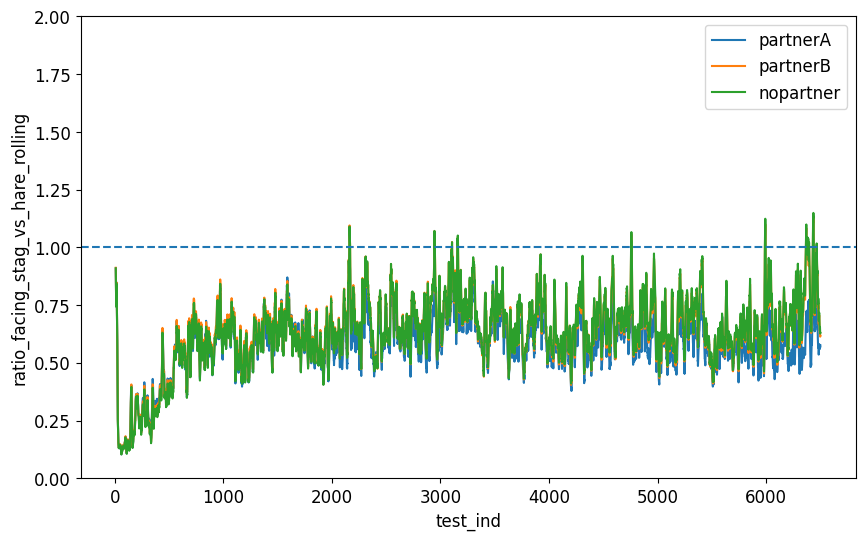

In [35]:
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling',  data=res_rolling_partnerA, label='partnerA')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_partnerB, label='partnerB')
sns.lineplot(x = 'test_ind', y='ratio_facing_stag_vs_hare_rolling', data=res_rolling_nopartner, label='nopartner')
plt.axhline(y=1, linestyle='--') 
plt.ylim(0, 2) # partial agent can hunt, ascii map, type B

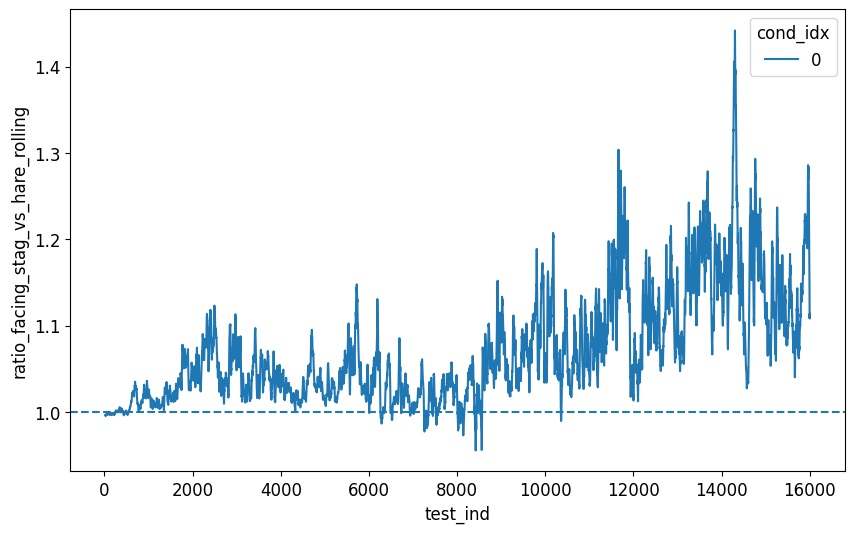

In [32]:
sns.lineplot(x='test_ind', y='ratio_facing_stag_vs_hare_rolling', hue='cond_idx', data=res_rolling_partnerA, )
plt.axhline(y=1, linestyle='--')
# plt.legend(labels=['experimental, eps=0.05', 'experimental, eps=1', 'control, eps=1'])

# multi-step probe test

## load data

In [2]:
f = [
    "test_full_identity_system_individual_recognition_v0_max_turns50_epsilon0_random_map_20251225-193541",
    "test_full_identity_system_2canhunt_v2_max_turns50_epsilon0_random_map_20251224-164843", # works
    "test_full_identity_system_2canhunt_v1_max_turns50_epsilon0_random_map_20251224-163713",
    "test_full_identity_system_2canhunt_v0_max_turns50_epsilon0_random_map_20251223-203104",
    "test_identity_system_2canhunt_max_turns50_epsilon0_random_map_20251222-230605",
    "test_identity_system_max_turns50_epsilon0_random_map_20251218-153309",
    "corrected_Dec13_not_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_test_multi_step_accurate_reward_allocation_max_turns50_epsilon0_random_map_20251213-154611",
    'corrected_Dec10_not_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_test_multi_step_max_turns50_epsilon0_random_map_20251210-213448',
    'corrected_Dec09_not_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_test_multi_step_max_turns50_epsilon0_random_map_20251209-152306',
    'corrected_Dec09_all_cannot_hunt_test_full_agent_spawning_stag100_spawn_lag_10_test_multi_step_max_turns50_epsilon0_random_map_20251209-152619',
    'corrected_Dec09_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_test_multi_step_max_turns50_epsilon0_random_map_20251209-152501',
    'Dec09_not_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_test_multi_step_max_turns50_epsilon0_random_map_20251209-001615'
][0]

res = []
num_a = 4
test_interval = 100
test_num = 24000
agent_identity_coding = True
partner_types = ['partner_AgentKindA', 'partner_AgentKindB', 'partner_no_partner']
for agent_ind in range(0, num_a):
    for test_ind in range(1, test_num):
        test_epoch = int(test_ind * test_interval)
        if not agent_identity_coding:
            for partner_type in partner_types:
                try:
                    df = pd.read_csv(os.path.join('../data', f+f'/unit_test/multi_step_probe_test_epoch_{test_epoch}_agent_{agent_ind}_map_test_multi_step_{partner_type}.csv'))
                    res.append(df)
                except:
                    continue
        else:
            for id in range(0, num_a):
                id = f'id_{id}'
                try:
                    df = pd.read_csv(os.path.join('../data', f+f'/unit_test/multi_step_probe_test_epoch_{test_epoch}_agent_{agent_ind}_map_test_multi_step_{id}.csv'))
                    res.append(df)
                except:
                    continue
res = pd.concat(res)
# factorize partner agent id
if 'partner_agent_id' in res.columns:
    pass
elif 'partner_kind' in res.columns:
    # If there's no partner_agent_id, assign a code based on partner_kind
    res['partner_agent_id'] = pd.factorize(res['partner_kind'])[0]
else:
    # Otherwise, just give dummy zeros
    res['partner_agent_id'] = 0


In [8]:
# grouped by partner kind
category_A_agent = [0, 1]
category_B_agent = [2]

res_A = res[res['agent_id'].isin(category_A_agent)].sort_values(by='epoch').groupby(['epoch', 'partner_kind'])['result'].mean().reset_index()
# res_A = res_A[res_A['partner_kind'] == 'AgentKindA']
res_B = res[res['agent_id'].isin(category_B_agent)].sort_values(by='epoch').groupby(['epoch', 'partner_kind'])['result'].mean().reset_index()

# add rolling metrics
rolling_res_A = res_A.copy()
rolling_res_B = res_B.copy()
wsize = 10
rolling_metrics_A = rolling_res_A.groupby('partner_kind').rolling(wsize, on='epoch')['result'].mean().reset_index()
rolling_metrics_A = rolling_metrics_A.rename(columns={'result': 'rolling_result'})
rolling_metrics_B = rolling_res_B.groupby('partner_kind').rolling(wsize, on='epoch')['result'].mean().reset_index()
rolling_metrics_B = rolling_metrics_B.rename(columns={'result': 'rolling_result'})
# rolling_res_A['rolling_result'] = rolling_res_A['result'].rolling(wsize).mean().reset_index(drop=True)
# rolling_res_B['rolling_result'] = rolling_res_B['result'].rolling(wsize).mean().reset_index(drop=True)


In [3]:
# grouped by partner agent id
wsize = 40

agent_ids = res['agent_id'].unique()
agent_ids = agent_ids[agent_ids != 'NA']
rolling_metrics_lst = []
for agent_id in agent_ids:
    res_agent = res[res['agent_id'] == agent_id]
    res_agent = res_agent.sort_values(by='epoch').groupby(['epoch', 'partner_agent_id'])['result'].mean().reset_index()
    rolling_res_agent = res_agent.copy()
    rolling_metrics_agent = rolling_res_agent.groupby('partner_agent_id').rolling(wsize, on='epoch')['result'].mean().reset_index()
    rolling_metrics_agent = rolling_metrics_agent.rename(columns={'result': 'rolling_result'})
    rolling_metrics_agent['agent_id'] = agent_id
    rolling_metrics_lst.append(rolling_metrics_agent)
rolling_metrics = pd.concat(rolling_metrics_lst)


In [9]:
rolling_metrics = rolling_metrics[rolling_metrics.partner_agent_id.isin([0, 1])]

## Plot

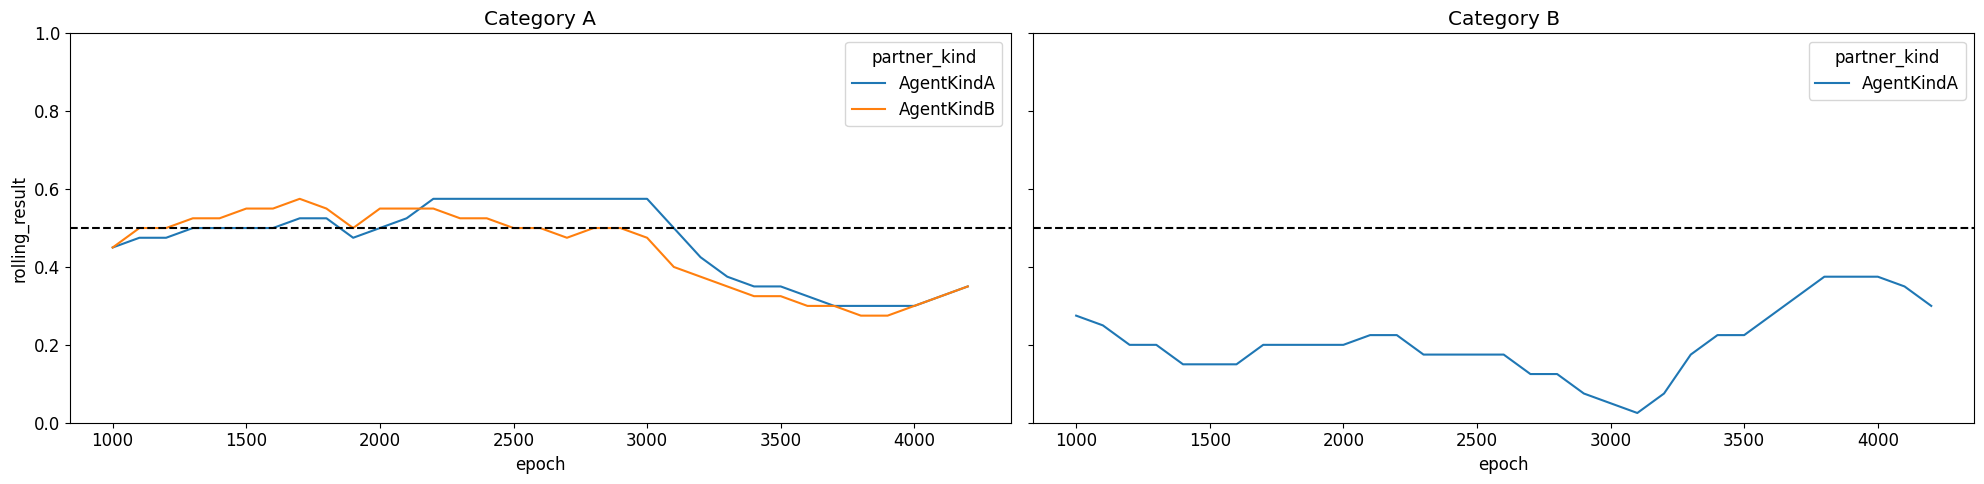

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharey=True)

sns.lineplot(x='epoch', y='rolling_result', hue='partner_kind', data=rolling_metrics_A, ax=axs[0])
axs[0].set_ylim(0, 1)
axs[0].axhline(y=0.5, linestyle='--', color='black')
axs[0].set_title('Category A')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('rolling_result')

sns.lineplot(x='epoch', y='rolling_result', hue='partner_kind', data=rolling_metrics_B, ax=axs[1])
axs[1].set_ylim(0, 1)
axs[1].axhline(y=0.5, linestyle='--', color='black')
axs[1].set_title('Category B')
axs[1].set_xlabel('epoch')
# axs[1].set_ylabel('rolling_result')

plt.tight_layout()
plt.show()


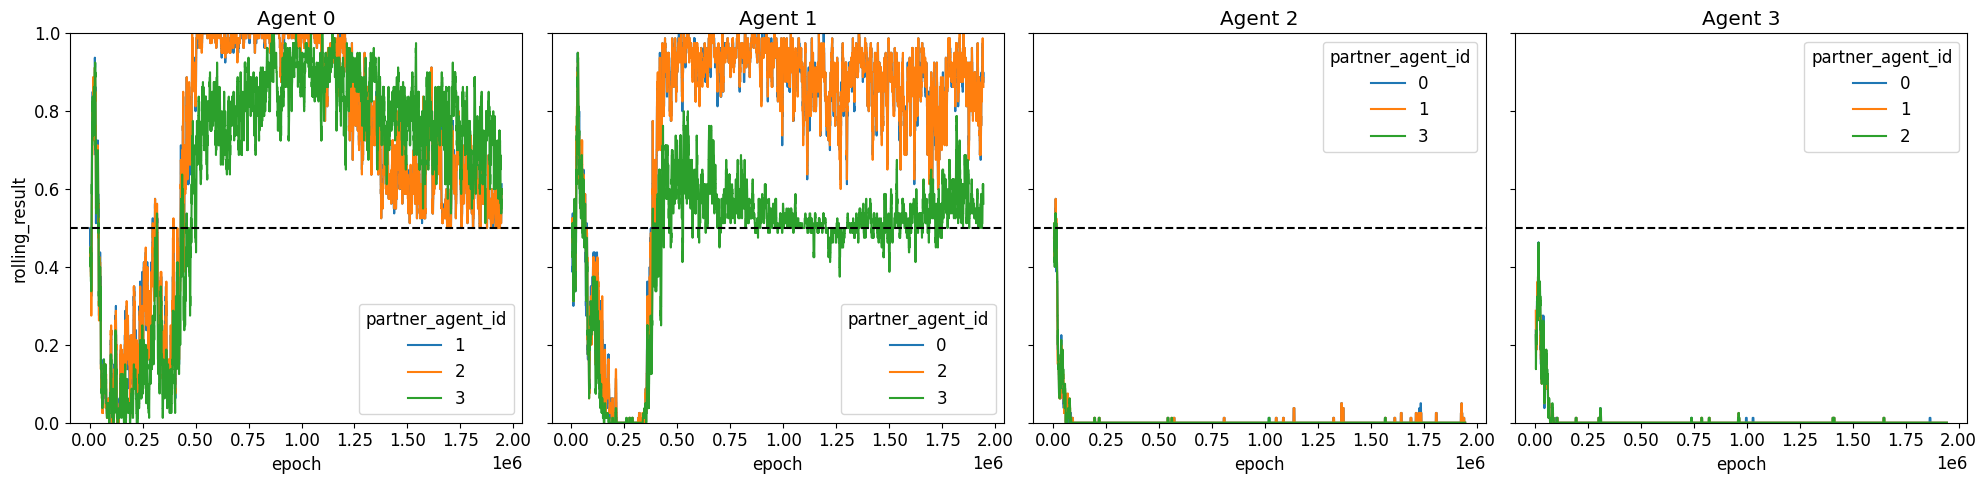

In [4]:
# subplot by agent id
fig, axs = plt.subplots(1, len(agent_ids), figsize=(20, 5), sharey=True)
for i, agent_id in enumerate(agent_ids):
    sns.lineplot(
        x='epoch', 
        y='rolling_result', 
        hue='partner_agent_id', 
        data=rolling_metrics[rolling_metrics['agent_id'] == agent_id], 
        ax=axs[i],
        #use a colorful palette
        palette='tab10')
    axs[i].set_ylim(0, 1)
    axs[i].axhline(y=0.5, linestyle='--', color='black')
    axs[i].set_title(f'Agent {agent_id}')
    # axs[i].tick_params(axis='x', labelrotation=30)
plt.tight_layout()
plt.show()


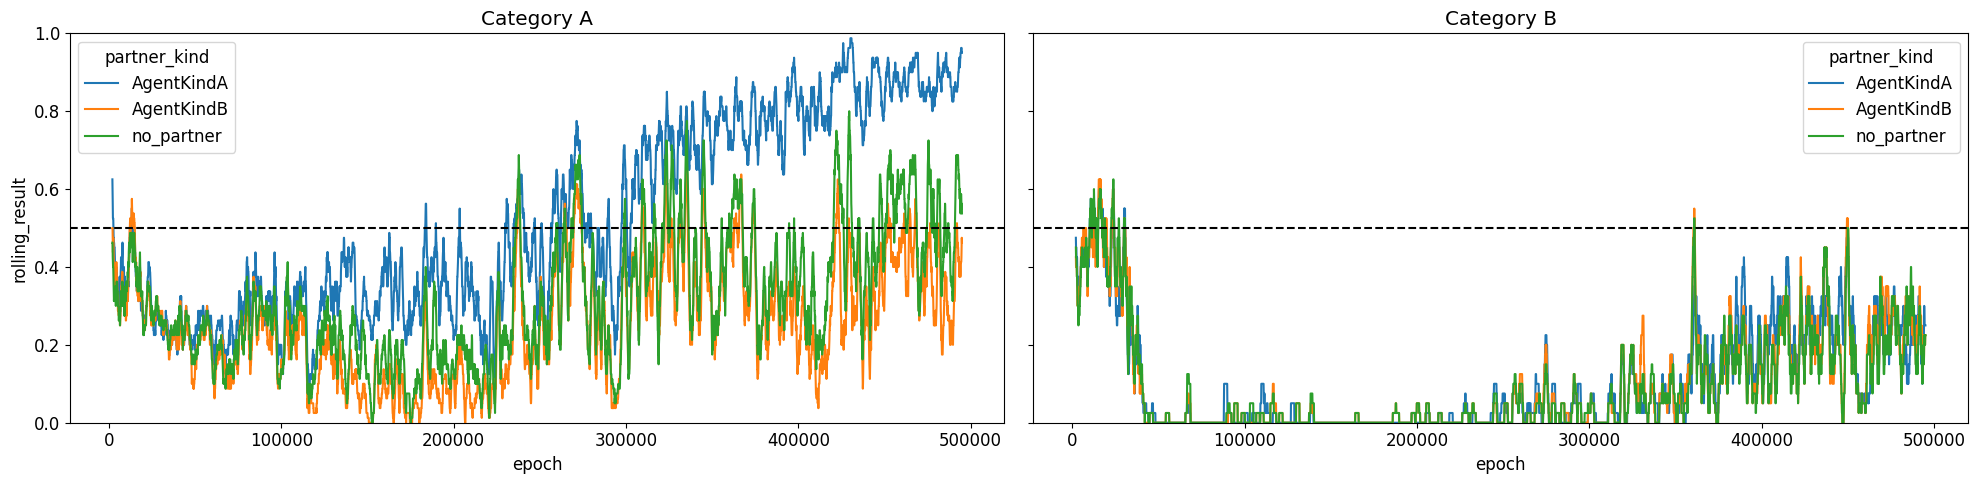

In [184]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharey=True)

sns.lineplot(x='epoch', y='rolling_result', hue='partner_kind', data=rolling_metrics_A, ax=axs[0])
axs[0].set_ylim(0, 1)
axs[0].axhline(y=0.5, linestyle='--', color='black')
axs[0].set_title('Category A')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('rolling_result')

sns.lineplot(x='epoch', y='rolling_result', hue='partner_kind', data=rolling_metrics_B, ax=axs[1])
axs[1].set_ylim(0, 1)
axs[1].axhline(y=0.5, linestyle='--', color='black')
axs[1].set_title('Category B')
axs[1].set_xlabel('epoch')
# axs[1].set_ylabel('rolling_result')

plt.tight_layout()
plt.show()


# Convert tensorboard logger files


In [34]:
parent_dir = '../runs_analysis/' # runs_p48
output_dir = 'res/runs_analysis/' # res/runs_p48_a2_deterministic
process_tensorboard_results(parent_dir, output_dir)

Data for tag 'loss' has been written to res/runs_analysis/Nov28_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_max_turns50_epsilon0_random_map_20251129-141444/loss_data.csv
Data for tag 'score' has been written to res/runs_analysis/Nov28_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_max_turns50_epsilon0_random_map_20251129-141444/score_data.csv
Data for tag 'epsilon' has been written to res/runs_analysis/Nov28_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_max_turns50_epsilon0_random_map_20251129-141444/epsilon_data.csv
Data for tag 'Agent_0/attacks_to_hares' has been written to res/runs_analysis/Nov28_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_max_turns50_epsilon0_random_map_20251129-141444/Agent_0_attacks_to_hares_data.csv
Data for tag 'Agent_0/attacks_to_stags' has been written to res/runs_analysis/Nov28_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_max_turns50_epsilon0_random_map_20251129-141444/Agent_0_attacks_to_st

In [5]:
## Plot stag attacks vs hares attacks

folders = [
    # "test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_20251106-015949",
    "Nov19_not_all_can_hunt_test_partial_agent_spawning_max_turns5_epsilon0_probe_test_map_20251120-210457"
]

condition_names = [
    # 'epsilon=1, experimental',
    'epsilon=0, experimental'
]

wsize = 100
df_lst_attacks_to_hares = []
df_lst_attacks_to_stags = []
for folder, condition_name in zip(folders, condition_names):
    df_attacks_to_hares = pd.read_csv(f'res/runs/{folder}/Mean_mean_attacks_to_hares_data.csv')
    val_attacks_to_hares = df_attacks_to_hares['Value'].rolling(wsize).mean().values
    df_lst_attacks_to_hares.append(val_attacks_to_hares)

    df_attacks_to_stags = pd.read_csv(f'res/runs/{folder}/Mean_mean_attacks_to_stags_data.csv')
    val_attacks_to_stags = df_attacks_to_stags['Value'].rolling(wsize).mean().values
    df_lst_attacks_to_stags.append(val_attacks_to_stags)

for i in range(len(df_lst_attacks_to_hares)):
    plt.plot(df_lst_attacks_to_hares[i], label=condition_names[i]+' attacks to hares')
    plt.plot(df_lst_attacks_to_stags[i], label=condition_names[i]+' attacks to stags')
plt.legend()
plt.ylabel('Number of attacks to hares/stags')


FileNotFoundError: [Errno 2] No such file or directory: 'res/runs/Nov19_not_all_can_hunt_test_partial_agent_spawning_max_turns5_epsilon0_probe_test_map_20251120-210457/Mean_mean_attacks_to_hares_data.csv'

In [41]:
len(df_lst_stags_defeated)

1

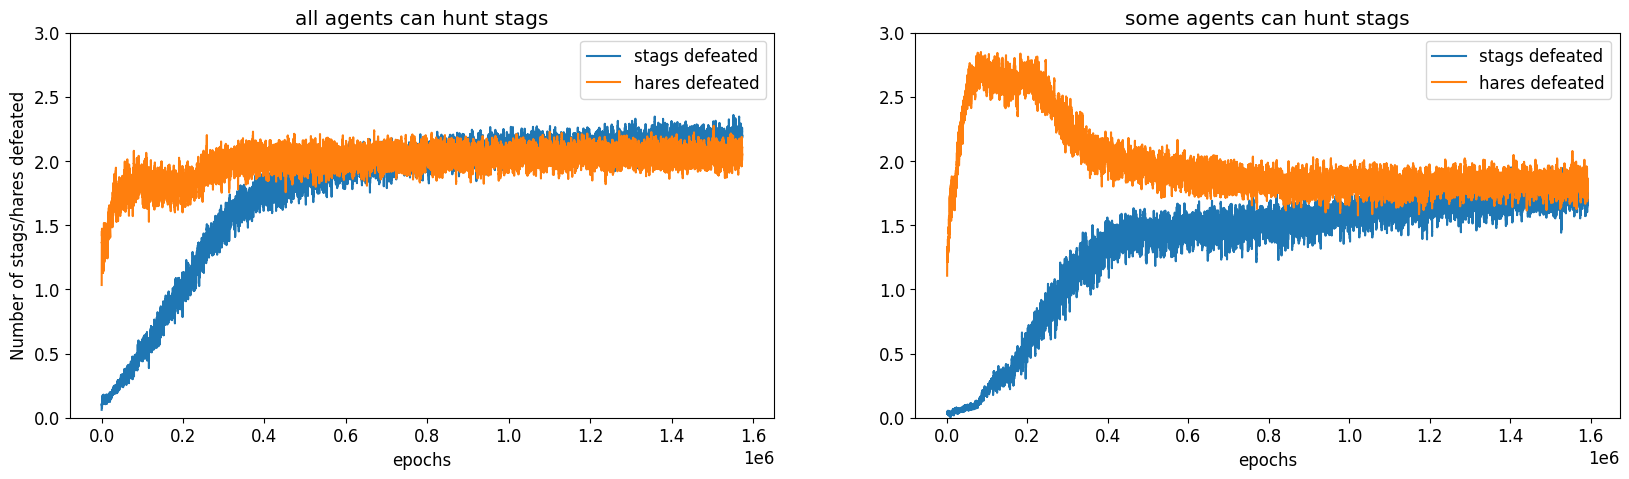

In [49]:
## Plot stag defeated vs hares defeated

folders = [
    # "test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_20251106-015949",
    # "runs_analysis/Nov28_not_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_B_cannot_share_max_turns50_epsilon0_random_map_20251202-164751"
    # "runs_analysis/Nov28_not_all_can_hunt_test_partial_agent_spawning_stag100_spawn_lag_10_max_turns50_epsilon0_random_map_20251128-130136"
    # "runs_analysis/Nov28_not_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_max_turns50_epsilon0_random_map_20251129-141354"
    "runs_analysis/Nov28_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_max_turns50_epsilon0_random_map_20251129-141444",
    "runs_analysis/Nov28_not_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_max_turns50_epsilon0_random_map_20251129-141354"
]

condition_names = [
    # 'epsilon=1, experimental',
    'all agents can hunt stags',
    'some agents can hunt stags'
]

wsize = 400
df_lst_stags_defeated = []
df_lst_hares_defeated = []
fig, axes = plt.subplots(1, len(folders), figsize=(20, 5))
for folder, condition_name in zip(folders, condition_names):
    df_stags_defeated = pd.read_csv(f'res/{folder}/Mean_mean_stags_defeated_data.csv')
    val_stags_defeated = df_stags_defeated['Value'].rolling(wsize).mean().values
    df_lst_stags_defeated.append(val_stags_defeated)

    df_hares_defeated = pd.read_csv(f'res/{folder}/Mean_mean_hares_defeated_data.csv')
    val_hares_defeated = df_hares_defeated['Value'].rolling(wsize).mean().values
    df_lst_hares_defeated.append(val_hares_defeated)

for i in range(len(df_lst_stags_defeated)):
    axes[i].plot(df_lst_stags_defeated[i], label='stags defeated')
    axes[i].plot(df_lst_hares_defeated[i], label='hares defeated')
    axes[i].set_title(condition_names[i])
    axes[i].set_ylim(0, 3)
    if i == 0:
        axes[i].set_ylabel('Number of stags/hares defeated')
    axes[i].set_xlabel('epochs')
    axes[i].legend()
# plt.legend()
# plt.ylim(0, 3
# plt.ylabel('Number of stags/hares defeated')
# plt.xlabel('epochs')


Text(0, 0.5, 'Number of stags/hares defeated')

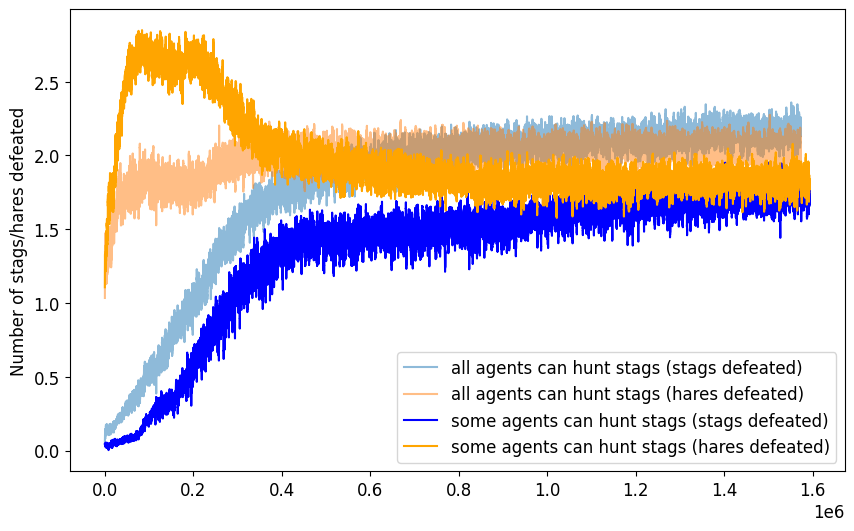

In [54]:
## Plot stag defeated vs hares defeated

folders = [
    # "test_vis4_area_attack_3a_Nov04_with_epsilon1_stag24_20251106-015949",
    # "runs_analysis/Nov28_not_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_B_cannot_share_max_turns50_epsilon0_random_map_20251202-164751"
     "runs_analysis/Nov28_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_max_turns50_epsilon0_random_map_20251129-141444",
    "runs_analysis/Nov28_not_all_can_hunt_test_full_agent_spawning_stag100_spawn_lag_10_max_turns50_epsilon0_random_map_20251129-141354"
]

condition_names = [
    # 'epsilon=1, experimental',
    'all agents can hunt stags',
    'some agents can hunt stags'
]

wsize = 400
df_lst_stags_defeated = []
df_lst_hares_defeated = []
for folder, condition_name in zip(folders, condition_names):
    df_stags_defeated = pd.read_csv(f'res/{folder}/Mean_mean_stags_defeated_data.csv')
    val_stags_defeated = df_stags_defeated['Value'].rolling(wsize).mean().values
    df_lst_stags_defeated.append(val_stags_defeated)

    df_hares_defeated = pd.read_csv(f'res/{folder}/Mean_mean_hares_defeated_data.csv')
    val_hares_defeated = df_hares_defeated['Value'].rolling(wsize).mean().values
    df_lst_hares_defeated.append(val_hares_defeated)

for i in range(len(df_lst_stags_defeated)):
    plt.plot(df_lst_stags_defeated[i], label=condition_names[i]+' (stags defeated)', color = ['tab:blue', 'blue'][i], alpha=[0.5, 1][i])
    plt.plot(df_lst_hares_defeated[i], label=condition_names[i]+' (hares defeated)', color=['tab:orange', 'orange'][i], alpha=[0.5, 1][i])
plt.legend()
plt.ylabel('Number of stags/hares defeated')
